# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- Direct comparison with scipy and reliability fits
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). Confirm that LBFGS can. 
- Confirm that it makes sense that the loss function can become negative. In most of the good fits I see, this is the case. 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 4
scale = 10

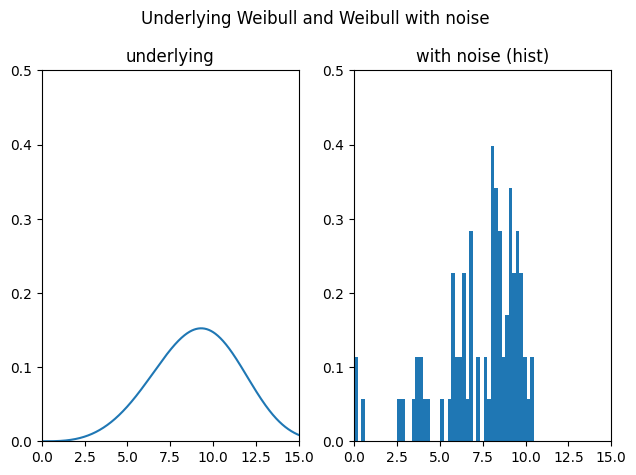

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

truncate = True 
trunc_limit = scale + .5
if truncate: 
    weibull_data = weibull_data[weibull_data < trunc_limit]
    
add_infant_mortality = True 
im_shape = .5
im_scale = scale/2
im_num_points = int(n/10)
if add_infant_mortality: 
    weibull_data = np.concatenate([weibull_data, weibull_min.rvs(c=im_shape, scale=im_scale, size=im_num_points)])

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 25, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=50, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 15)
    ax[idx].set_ylim(0, .5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

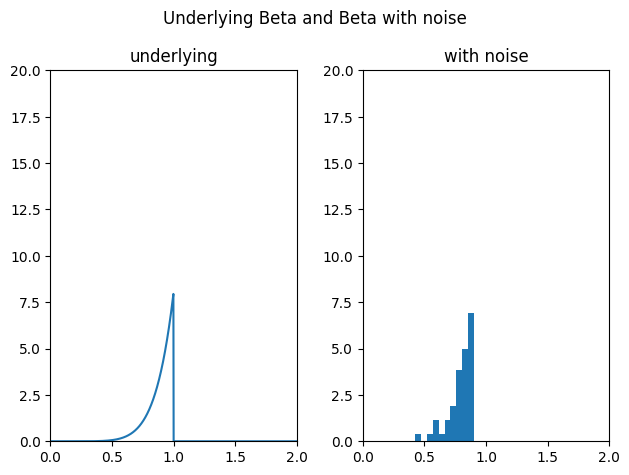

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

truncate = True 
trunc_limit = .9
if truncate: 
    beta_data = beta_data[beta_data < trunc_limit]


#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 0.752389669418335, 1.3946685791015625, 2050.3546959828536
iter 100: 1.2289069890975952, 0.8300961852073669, 424.8521173427019
iter 200: 1.3546359539031982, 0.6292734742164612, 350.87144419854724
iter 300: 1.4270045757293701, 0.5392035841941833, 337.4975460317509
iter 400: 1.48360013961792, 0.5057575702667236, 334.19262704559475
iter 500: 1.5362272262573242, 0.4989386200904846, 332.43391612749326
iter 600: 1.5889972448349, 0.5030587911605835, 330.8226559948382
iter 700: 1.6431211233139038, 0.511326789855957, 329.1886387922849
iter 800: 1.6987413167953491, 0.5211887955665588, 327.5274374386139
iter 900: 1.7556703090667725, 0.5317495465278625, 325.84973815360723
iter 1000: 1.813653826713562, 0.5426945686340332, 324.16494486815407
iter 1100: 1.8724560737609863, 0.553903341293335, 322.4801619213721
iter 1200: 1.931876540184021, 0.5653203725814819, 320.8006793474879
iter 1300: 1.9917504787445068, 0.5769139528274536, 319.13036801986743
iter 1400: 2.051942586898803

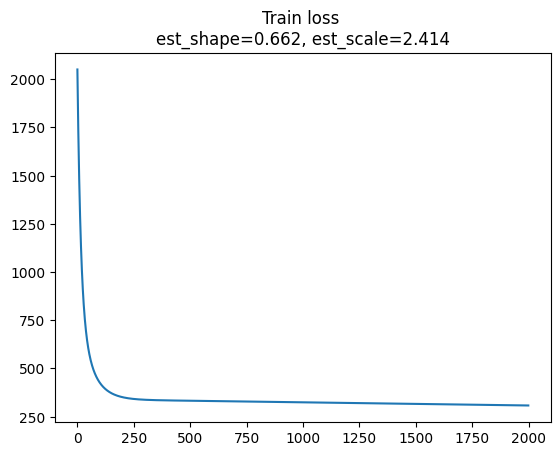

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


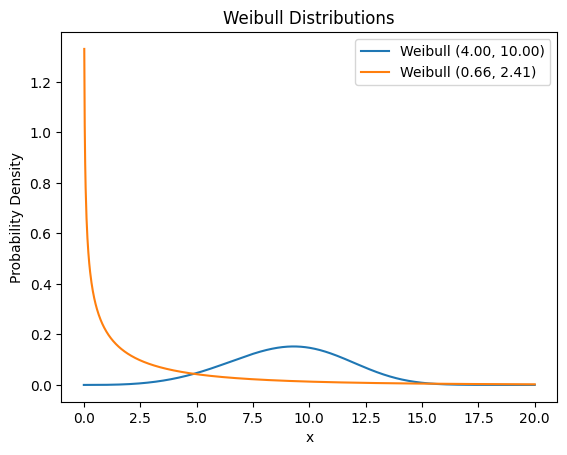

Actual shape=4


In [10]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 0.12383890897035599, 2.504794120788574, 7056.0610399314955
iter 100: 0.36026906967163086, 2.236294984817505, 173.39371853199842
iter 200: 0.4200700521469116, 2.1662611961364746, 90.60245640958505
iter 300: 0.4627728760242462, 2.125070095062256, 58.39633454833612
iter 400: 0.4962056875228882, 2.1008810997009277, 41.87455378208532
iter 500: 0.5237720012664795, 2.0880563259124756, 31.989280982983818
iter 600: 0.5472572445869446, 2.083406925201416, 25.442626751345372
iter 700: 0.567718505859375, 2.084911346435547, 20.77307394609639
iter 800: 0.5858345627784729, 2.0911924839019775, 17.245367874483673
iter 900: 0.6020684242248535, 2.1012532711029053, 14.45500233186945
iter 1000: 0.6167489290237427, 2.114347457885742, 12.164361428879648
iter 1100: 0.630119800567627, 2.129896879196167, 10.226263476372516
iter 1200: 0.6423668265342712, 2.1474432945251465, 8.545751260113077
iter 1300: 0.6536344885826111, 2.166623115539551, 7.059354360397379
iter 1400: 0.6640379428863

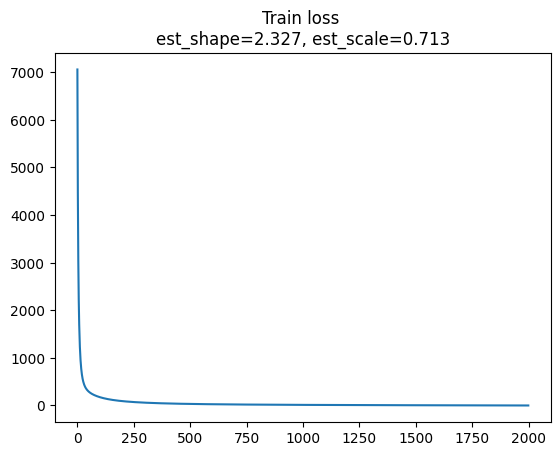

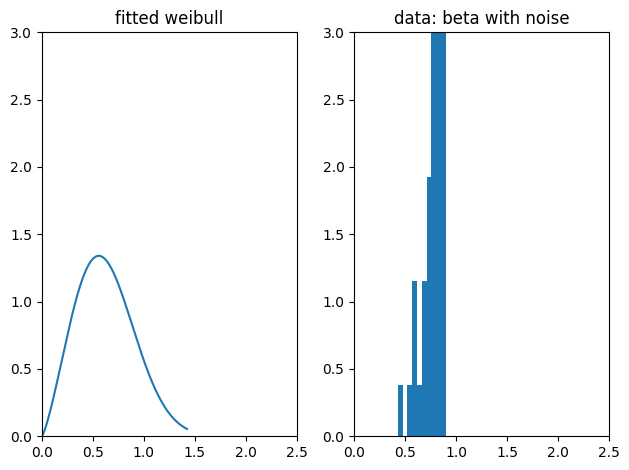

In [11]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 3.960744857788086, 1.3323729038238525, 275.8360727226034
iter 0: 4.01016092300415, 1.2817888259887695, 272.41381091522544
iter 0: 4.038727283477783, 1.2678951025009155, 271.14395089289724
iter 0: 4.086691379547119, 1.2573305368423462, 269.4671981232092
iter 0: 4.161244869232178, 1.2523596286773682, 267.2732012240436
iter 0: 4.273952007293701, 1.255825161933899, 264.35882320062325
iter 0: 4.439650535583496, 1.271836519241333, 260.4910809402189
iter 0: 4.673247337341309, 1.305393099784851, 255.49049458821673
iter 0: 4.979494094848633, 1.3603308200836182, 249.43637347833717
iter 0: 5.33873987197876, 1.4354950189590454, 242.8748009680237
iter 0: 5.709415435791016, 1.5237094163894653, 236.62563357668876
iter 0: 6.054472923278809, 1.617271065711975, 231.2315087101344
iter 0: 6.356655120849609, 1.7124128341674805, 226.78812792658476
iter 0: 6.611523628234863, 1.8058347702026367, 223.2193130466144
iter 0: 6.823145389556885, 1.8924627304077148, 220.42430582675567
it

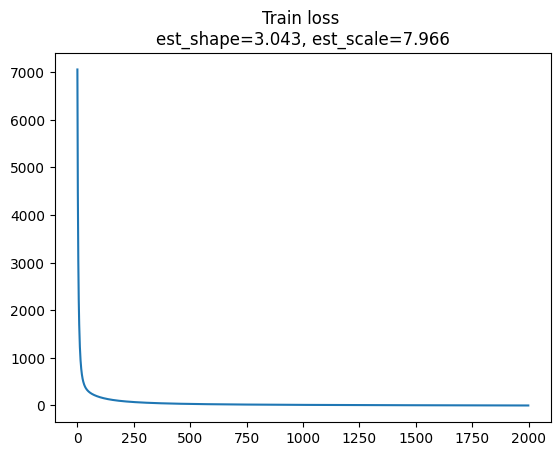

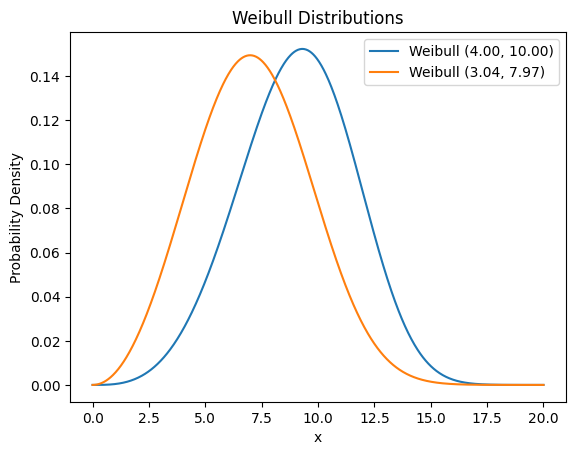

Actual shape=4


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 0.4764518737792969, 3.3244378566741943, 141.38494685464738
iter 0: 0.5699421167373657, 3.3179280757904053, 34.05290610743909
iter 0: 0.5756370425224304, 3.3177907466888428, 30.300675434750225
iter 0: 0.585026741027832, 3.317949056625366, 24.587079981380693
iter 0: 0.5942366123199463, 3.3185067176818848, 19.5066275121705
iter 0: 0.6034327149391174, 3.3194878101348877, 14.904012791088542
iter 0: 0.6125926375389099, 3.320911407470703, 10.744699622684497
iter 0: 0.621702253818512, 3.322796106338501, 6.991780973097469
iter 0: 0.6307462453842163, 3.3251583576202393, 3.6111764511075553
iter 0: 0.639708936214447, 3.3280131816864014, 0.5711339081120967
iter 0: 0.6485742926597595, 3.331373453140259, -2.1579230247348815
iter 0: 0.6573261618614197, 3.335249662399292, -4.603518698163181
iter 0: 0.6659485101699829, 3.3396501541137695, -6.791281625318023
iter 0: 0.6744254231452942, 3.34458065032959, -8.745010101376105
iter 0: 0.6827415227890015, 3.3500442504882812, -10.48

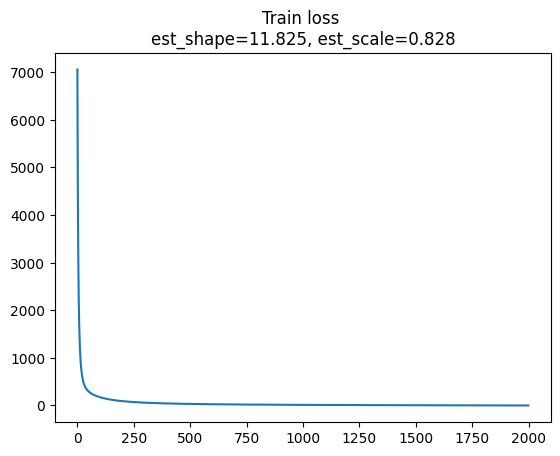

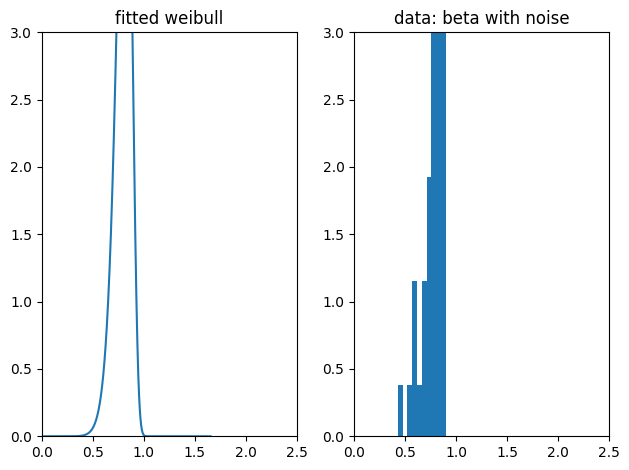

In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

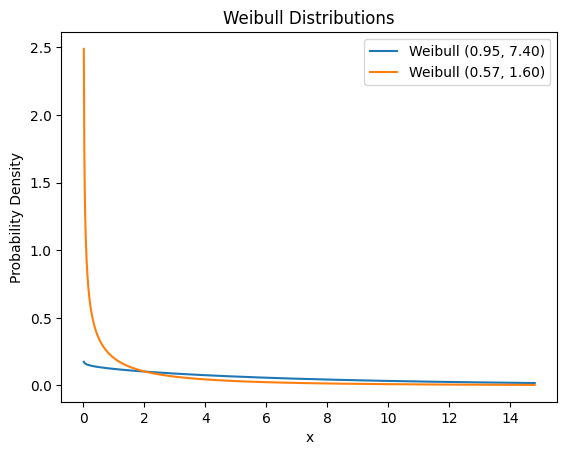

In [14]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))